In [1]:
from PIL import Image
import requests
import torch
from transformers import CLIPProcessor, CLIPModel
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import random
import open_clip

from util import *
from scipy.stats import kurtosis
import numpy as np
from util_hypothesis_test import *
from joblib import Parallel, delayed

/home/jitian/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
random.seed(1234)

# Define the WhiteNoiseDataset
class WhiteNoiseDataset(Dataset):
    def __init__(self, num_images, height, width, channels):
        self.num_images = num_images
        self.height = height
        self.width = width
        self.channels = channels

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        # Generate a white noise image
        image_array = np.random.randint(0, 256, (self.height, self.width, self.channels), dtype=np.uint8)
        image = Image.fromarray(image_array.astype('uint8'), 'RGB')
        return image

# Load model and preprocessor from open_clip
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define the collate function for the DataLoader
def collate_fn_whitenoise(batch):
    # batch is a list of images
    images = [preprocess(image) for image in batch]
    inputs = torch.stack(images)
    return inputs

# Set parameters for white noise images and batch size
num_images = 5000
height, width, channels = 224, 224, 3
batch_size = 64

# Create the white noise dataset and DataLoader
white_noise_dataset = WhiteNoiseDataset(num_images, height, width, channels)
dataloader = DataLoader(
    white_noise_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn_whitenoise
)

# Determine the embedding dimension from the model
embedding_dim = model.visual.output_dim  # open_clip model's embedding dimension

# Preallocate a tensor to store all embeddings
white_noise_image_embeddings = torch.empty((num_images, embedding_dim), device=device)

# Process and feed the white noise images into the model
start_idx = 0
for inputs in tqdm(dataloader):
    # Move inputs to the device
    inputs = inputs.to(device)

    # Get embeddings with the open_clip model
    with torch.no_grad():
        image_features = model.encode_image(inputs)  # (batch_size, embedding_dim)

    # Store the batch embeddings into the preallocated tensor
    end_idx = start_idx + image_features.size(0)
    white_noise_image_embeddings[start_idx:end_idx] = image_features
    start_idx = end_idx

# Optionally, save the embeddings
torch.save(white_noise_image_embeddings.cpu(), '../computed_embeddings/white_noise_image_embeddings.pt')
print("Embeddings saved to 'white_noise_image_embeddings.pt'")

100%|██████████| 79/79 [00:03<00:00, 23.50it/s]

Embeddings saved to 'white_noise_image_embeddings.pt'


## white noise image

In [16]:
k = 100
L = glaplacian(white_noise_image_embeddings.to('cpu'))
U, S, Vt = randomized_svd(L, n_components=k)

In [17]:
class WhiteNoiseDataset(Dataset):
    def __init__(self, num_images, height, width, channels):
        self.num_images = num_images
        self.height = height
        self.width = width
        self.channels = channels
    
    def __len__(self):
        return self.num_images
    
    def __getitem__(self, idx):
        # Generate a single white noise image
        white_noise_image = np.random.rand(self.height, self.width, self.channels) * 255
        return white_noise_image.astype(np.uint8)  # Return as uint8 to simulate image
    

def random_rotation_matrix(n=3):
    A = np.random.randn(n, n)
    Q, R = np.linalg.qr(A)
    # Ensure a positive determinant
    if np.linalg.det(Q) < 0:
        Q[:, -1] = -Q[:, -1]
    return Q

# def rotate_matrix(Z):
#     n_rows, n_cols = Z.shape

#     # Generate a batch of random rotation matrices
#     rotation_matrices = np.array([random_rotation_matrix(n_cols) for _ in range(n_rows)])

#     # Efficiently apply the rotation to each row of Z using batch matrix multiplication
#     rotated_matrix = np.einsum('ijk,ik->ij', rotation_matrices, Z)
#     return rotated_matrix


def rotate_matrix(Z):
    n_rows, n_cols = Z.shape

    # Generate a random rotation matrix for each row in parallel
    rotation_matrices = Parallel(n_jobs=-1)(
        delayed(random_rotation_matrix)(n_cols) for _ in range(n_rows)
    )

    # Convert the list of rotation matrices into a NumPy array
    rotation_matrices = np.array(rotation_matrices)

    # Efficiently apply the rotation to each row of Z using batch matrix multiplication
    rotated_matrix = np.einsum('ijk,ik->ij', rotation_matrices, Z)
    
    return rotated_matrix

def compute_kurtosis_stat(Z):
    return kurtosis(Z, axis = 0)

# def compute_varimax_stat(Z):
#     n, k = Z.shape  # AssZming Z is n x k and R is k x k
#     total_sum = 0
#     for ell in range(k):
#         # Compute the first term: Sum of the fourth powers of elements in column `ell` of UR
#         first_term = np.sum(Z[:, ell]**4)
#         # Compute the second term: (Sum of squares of the elements in column `ell` of U)^2
#         second_term = (np.sum(Z[:, ell]**2)**2) / n
#         # Combine the terms and add to total sum
#         total_sum += (first_term - second_term) / n
#     return total_sum

def compute_varimax_stat(Z):
    n, k = Z.shape
    first_term = np.sum(Z**4, axis=0)
    second_term = (np.sum(Z**2, axis=0)**2) / n
    total_sum = np.sum((first_term - second_term) / n)
    return total_sum

def rotate_matrix_cuda(Z, chunk_size=5000):
    Z = Z.to('cuda')
    n_rows, n_cols = Z.shape

    rotated_matrix = torch.zeros_like(Z, device='cuda')

    for i in range(0, n_rows, chunk_size):
        # Process in chunks
        chunk = Z[i:i+chunk_size]

        # Generate random rotation matrices for the chunk
        rotation_matrices = torch.stack([random_rotation_matrix_cuda(n_cols).to('cuda') for _ in range(chunk.shape[0])])

        # Perform batch matrix multiplication for the chunk
        rotated_matrix[i:i+chunk_size] = torch.bmm(rotation_matrices, chunk.unsqueeze(2)).squeeze(2)

    return rotated_matrix

# Example random rotation matrix function (ensure this is CUDA-friendly)
def random_rotation_matrix_cuda(n):
    # Generate a random orthogonal matrix (this is an example, ensure it's on the correct device)
    q, _ = torch.qr(torch.randn(n, n, device='cuda'))
    return q

def compute_rescaled_kurtosis(Z):
    n = np.size(Z)
    A = np.mean(kurtosis(Z, axis = 0)*np.sqrt(n)/np.sqrt(33))
    return (A)

def hypothesis_testing(U, num_resamples=50, return_test_statistic=True):
    def single_resample(_):
        U_rot = rotate_matrix(U)  # Rotate the matrix U
        Z_rot = varimax(U_rot)  # Perform Varimax rotation
        kurtosis_values = compute_kurtosis_stat(Z_rot)  # Compute kurtosis statistics
        varimax_obj = compute_varimax_stat(Z_rot)  # Compute Varimax objective
        rescaled_kurtosis_values = compute_rescaled_kurtosis(Z_rot) # TS3
        return np.mean(kurtosis_values), varimax_obj, rescaled_kurtosis_values
    results = Parallel(n_jobs=-1)(delayed(single_resample)(_) for _ in tqdm(range(num_resamples)))
    aggregated_kurtosis, null_varimax, aggregated_rescaled_kurtosis = zip(*results)  
  
    # Compute test statistics
    Z_hat = varimax(U)
    test_kurtosis_value = kurtosis(Z_hat, axis=0)
    test_varimax_obj = compute_varimax_stat(Z_hat)
    test_rescaled_kutosis_value = compute_rescaled_kurtosis(Z_hat)

    # Calculate p-values
    p_val_kurtosis = np.mean(np.array(aggregated_kurtosis) >= np.mean(test_kurtosis_value))
    p_val_rescaled_kurtosis = np.mean(np.array(aggregated_rescaled_kurtosis) >= np.mean(test_rescaled_kutosis_value))
    p_val_varimax = np.mean(np.abs(null_varimax) >= np.abs(test_varimax_obj))

    # Return p-values and optionally test statistics
    if return_test_statistic:
        return p_val_kurtosis, p_val_varimax, p_val_rescaled_kurtosis, aggregated_kurtosis, aggregated_rescaled_kurtosis, np.mean(test_kurtosis_value), null_varimax, test_varimax_obj
    else:
        return p_val_kurtosis, p_val_varimax, p_val_rescaled_kurtosis

In [18]:
res = hypothesis_testing(U, num_resamples=50, return_test_statistic=True)

100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


In [20]:
print(res[:3])

(0.2, 0.78, 0.2)


In [31]:
print('null kurtosis average: ', np.mean(res[3]))
print('observed kurtosis: ', np.mean(res[5]))

null kurtosis average:  3.1891164743401346
observed kurtosis:  3.22943030669285


In [32]:
print('null varimax: ', np.mean(res[-2]))
print('observed varimax: ', res[-1])

null varimax:  2.1331487971724774e-05
observed varimax:  2.1139073180687982e-05


## white noise embeddings

In [33]:
num_images = 10000
embedding_dim = 512
white_noise_embeddings = np.random.normal(0, 1, num_images * embedding_dim)
white_noise_embeddings = white_noise_embeddings.reshape(num_images, embedding_dim)
k = 100
L = glaplacian(white_noise_embeddings)
U, S, Vt = randomized_svd(L, n_components=k)

In [34]:
res2 = hypothesis_testing(U, num_resamples=50, return_test_statistic=True)

100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


In [35]:
print(res2[:3])

(0.66, 0.66, 0.66)


In [36]:
print('null kurtosis average: ', np.mean(res2[3]))
print('observed kurtosis: ', np.mean(res2[5]))
print('null varimax: ', np.mean(res2[-2]))
print('observed varimax: ', res2[-1])

null kurtosis average:  0.6510601290832669
observed kurtosis:  0.6467448681828596
null varimax:  2.652594369702852e-06
observed varimax:  2.6466632362981764e-06


### for real image embeddings

In [37]:
image_features = torch.load('../computed_embeddings/image_features_512d.pt')

In [38]:
k = 100
L = glaplacian(image_features)
U, S, Vt = randomized_svd(L, n_components=k)

In [14]:
res3 = hypothesis_testing(U, num_resamples=100, return_test_statistic=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [143]:
print(np.mean(res3[3]))

0.21679021070275203


In [144]:
print(res3[6])

8.115046304383613


In [145]:
np.array(res3[3] >= res3[6])

array([False, False, False, False, False, False, False, False, False,
       False])

In [146]:
print(res3[:3])

(0.0, 0.0, 0.0)


In [117]:
k = 50
L = glaplacian(image_features)

num_rows = 10000
num_cols = 512

# Randomly choose row and column indices
np.random.seed(42)  # For reproducibility
random_rows = np.random.choice(50000, num_rows, replace=False)
random_cols = np.random.choice(512, num_cols, replace=False)
L_draw = L[random_rows][:, random_cols]

U, S, Vt = randomized_svd(L_draw, n_components=k)
S_diag = np.diag(S)
Z = U @ S_diag
Z_rotated, Rz = varimax_with_rotation(Z)
sign_Z = np.diag(np.where(np.mean(Z_rotated**3, axis=0) >= 0, 1, -1))
Z_hat = Z_rotated @ sign_Z
Y_hat = sign_Z @ Rz.T @ Vt
bootstrap_data_aggregated = hypothesis_testing(Z_hat, num_resamples=1000, return_test_statistic=True)

100%|██████████| 1000/1000 [32:14<00:00,  1.93s/it]


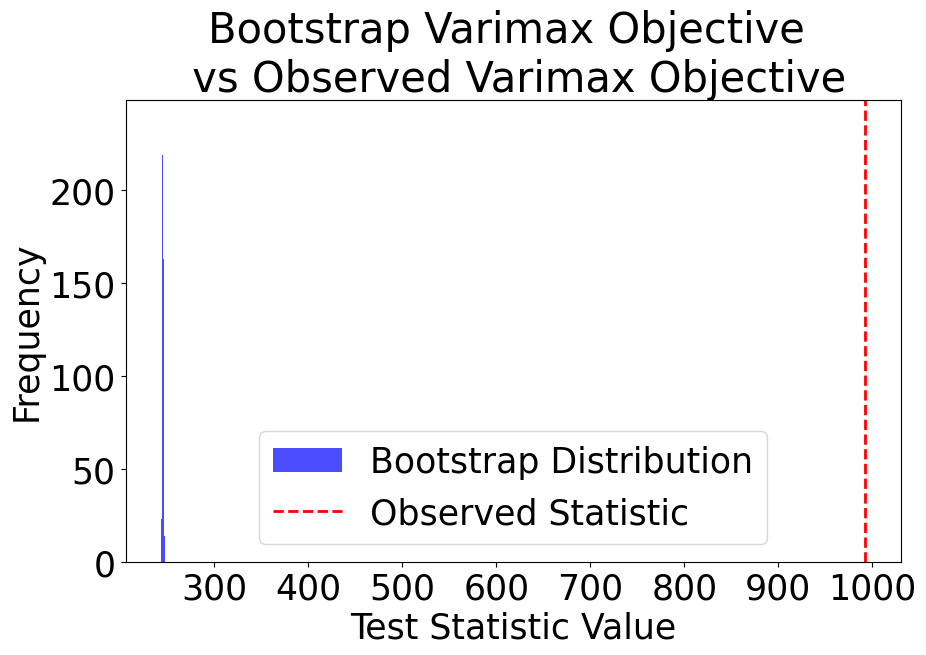

In [181]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate bootstrap data (this would be your actual bootstrap results)
#bootstrap_data =np.array(bootstrap_data_aggregated[3])
bootstrap_data =np.array(bootstrap_data_aggregated[5])*10**15

# Observed Varimax Objective value (you should replace this with your actual value)
#observed_statistic = compute_kurtosis_stat(Z_hat)
#observed_statistic = compute_rescaled_kurtosis(Z_hat)
observed_statistic = compute_varimax_stat(Z_hat)*10**15

# Setting the font size globally
plt.rcParams.update({'font.size': 14})  # You can adjust the size as needed

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_data, color='blue', alpha=0.7, label='Bootstrap Distribution')

# Add a vertical line for the observed statistic
plt.axvline(observed_statistic, color='red', linestyle='dashed', linewidth=2, label='Observed Statistic')

# Adding labels and title
plt.title('Bootstrap Varimax Objective \n vs Observed Varimax Objective', fontsize=30)
plt.xlabel('Test Statistic Value', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
plt.legend(fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# Show plot
plt.show()


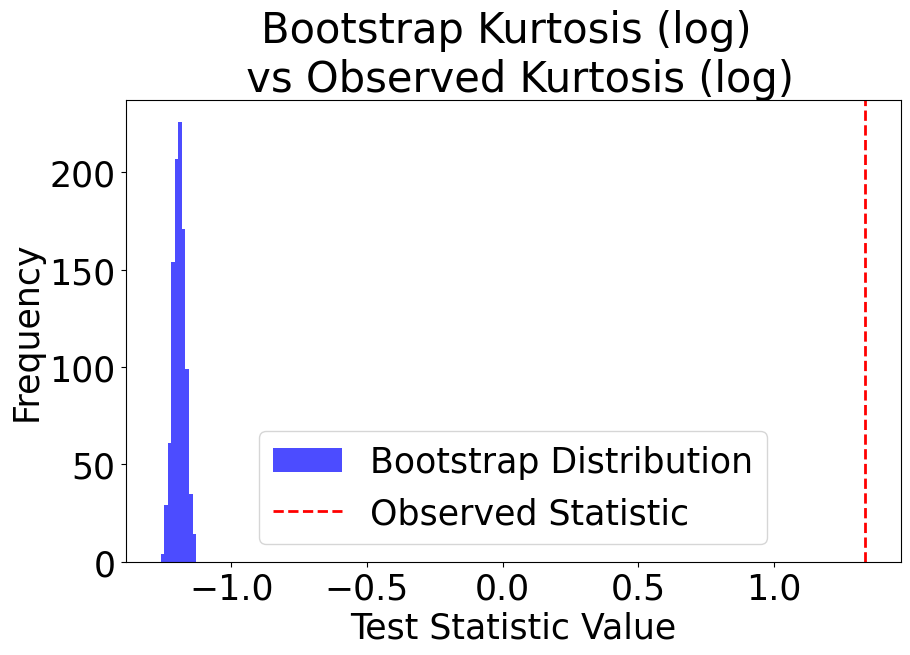

In [177]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate bootstrap data (this would be your actual bootstrap results)
bootstrap_data =np.array(bootstrap_data_aggregated[3])
#bootstrap_data =np.array(bootstrap_data_aggregated[5])*10**15

# Observed Varimax Objective value (you should replace this with your actual value)
observed_statistic = np.mean(compute_kurtosis_stat(Z_hat))
#observed_statistic = compute_rescaled_kurtosis(Z_hat)
#observed_statistic = compute_varimax_stat(Z_hat)*10**15

# Setting the font size globally
plt.rcParams.update({'font.size': 14})  # You can adjust the size as needed

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(np.log(bootstrap_data), color='blue', alpha=0.7, label='Bootstrap Distribution')

# Add a vertical line for the observed statistic
plt.axvline(np.log(observed_statistic), color='red', linestyle='dashed', linewidth=2, label='Observed Statistic')

# Adding labels and title
plt.title('Bootstrap Kurtosis (log) \n vs Observed Kurtosis (log)', fontsize=30)
plt.xlabel('Test Statistic Value', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
plt.legend(fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# Show plot
plt.show()


array([-0.13413326,  0.34941022,  2.25267114,  5.00593762,  8.46645357,
        5.75891278,  3.11847108,  4.84064483,  1.12739441, 10.01867363,
        6.23866185, 13.89936728,  6.76665435,  1.51145486,  6.92138426,
        7.56317249,  2.73583955,  7.83280176,  1.49797086,  5.27456898,
        3.04983086,  0.51722462,  0.99512623,  7.32066047,  0.50835343,
        7.41409719,  1.80753868,  3.34687986,  5.07927409,  4.90843655,
        6.76773386,  7.07675301,  4.16616521,  0.49280885,  2.90156789,
        3.14923255,  2.89991076,  2.62611668,  0.62376052,  3.8245204 ,
        2.24519547,  2.81014456,  1.81290378,  0.15786478,  2.85104953,
        3.06923676,  0.43338983,  5.14816205,  0.77580291,  0.42807513])

White noise

In [182]:
num_images = 10000
embedding_dim = 512
white_noise_embeddings = np.random.normal(0, 1, num_images* embedding_dim)
white_noise_embeddings = white_noise_embeddings.reshape(num_images, embedding_dim)
# white_noise_embeddings = np.random.randn(num_images, embedding_dim)
# zero_columns =  0.00001 * np.random.randn(white_noise_embeddings.shape[0], 50)
# white_noise_embeddings = np.hstack((white_noise_embeddings, zero_columns))
k = 50
L = glaplacian(white_noise_embeddings)
U, S, Vt = randomized_svd(L, n_components=k)
S_diag = np.diag(S)
Z = U @ S_diag
Z_rotated, Rz = varimax_with_rotation(Z)
sign_Z = np.diag(np.where(np.mean(Z_rotated**3, axis=0) >= 0, 1, -1))
Z_hat = Z_rotated @ sign_Z
Y_hat = sign_Z @ Rz.T @ Vt

bootstrap_data_aggregated = hypothesis_testing(Z_hat, num_resamples=1000, return_test_statistic=True)

100%|██████████| 1000/1000 [31:25<00:00,  1.89s/it]


In [189]:
bootstrap_data_aggregated[5]

[2.463388068627991e-13,
 2.464350242379875e-13,
 2.453148108716332e-13,
 2.453480766542824e-13,
 2.4540818469737413e-13,
 2.4469595501669496e-13,
 2.4411084342238083e-13,
 2.467326336903952e-13,
 2.465403547440186e-13,
 2.446988965699534e-13,
 2.451685296245909e-13,
 2.4510359934763177e-13,
 2.4584559201371916e-13,
 2.451307974840889e-13,
 2.4620848115539177e-13,
 2.456071851850704e-13,
 2.4487054699782e-13,
 2.449206248233401e-13,
 2.4558930378921676e-13,
 2.452923462511113e-13,
 2.451239646312277e-13,
 2.4510342370404173e-13,
 2.450708280927297e-13,
 2.460079239927671e-13,
 2.444928446383269e-13,
 2.470149322013862e-13,
 2.4496636340079074e-13,
 2.4487030269735254e-13,
 2.444869272206436e-13,
 2.454191787383412e-13,
 2.4545158979596004e-13,
 2.4524786352170293e-13,
 2.453777692443421e-13,
 2.4605826404885396e-13,
 2.4446976643093123e-13,
 2.455567833641071e-13,
 2.453010974217104e-13,
 2.4524191247229234e-13,
 2.4501365077768303e-13,
 2.454490434890767e-13,
 2.4550656224234527e-13,
 

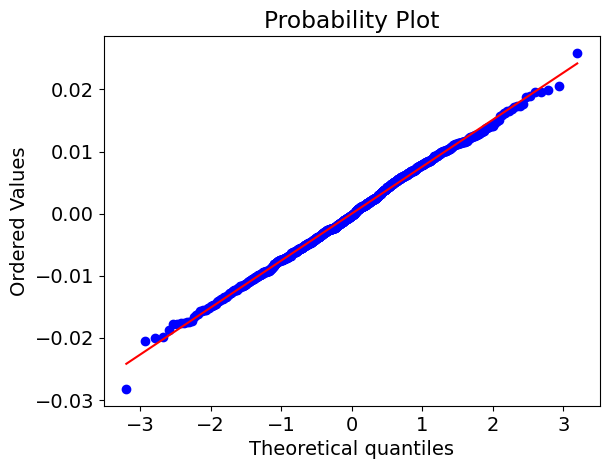

In [192]:
import scipy.stats as stats
import pylab 

measurements=np.array(bootstrap_data_aggregated[4])*np.sqrt(33)/np.sqrt(np.size(Z_hat))-np.mean(np.array(bootstrap_data_aggregated[4])*np.sqrt(33)/np.sqrt(np.size(Z_hat)))
stats.probplot(measurements, dist="norm", plot=pylab)
pylab.show()


White noise image

In [ ]:
k = 50
L = glaplacian(all_image_features.to('cpu'))
U, S, Vt = randomized_svd(L, n_components=k)
S_diag = np.diag(S)
Z = U @ S_diag
Z_rotated, Rz = varimax_with_rotation(Z)
sign_Z = np.diag(np.where(np.mean(Z_rotated**3, axis=0) >= 0, 1, -1))
Z_hat = Z_rotated @ sign_Z
Y_hat = sign_Z @ Rz.T @ Vt

bootstrap_data_aggregated = hypothesis_testing(Z_hat, num_resamples=1000, return_test_statistic=True)